In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [5]:
stats = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/bare/output/ocean.stats.nc', decode_times=False)
stats_zb = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/ZB/output/ocean.stats.nc', decode_times=False)
stats_ssd = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/ZB_ssd/output/ocean.stats.nc', decode_times=False)
stats_smooth = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/ZB_smooth/output/ocean.stats.nc', decode_times=False)
stats_reynolds = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/ZB_reynolds/output/ocean.stats.nc', decode_times=False)
stats_hires = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/5km/output/ocean.stats.nc', decode_times=False)

Text(0, 0.5, 'KE in Joules')

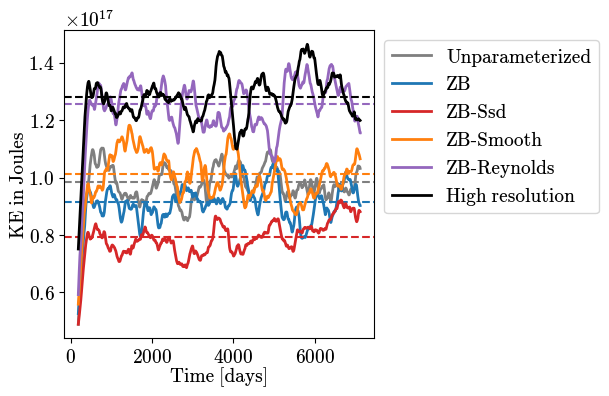

In [28]:
default_rcParams({'axes.formatter.limits': (-5,5)})
for s, label, color in zip(
    [stats, stats_zb, stats_ssd, stats_smooth, stats_reynolds, stats_hires], 
    ['Unparameterized', 'ZB', 'ZB-Ssd', 'ZB-Smooth', 'ZB-Reynolds', 'High resolution'],
    ['tab:gray', 'tab:blue', 'tab:red', 'tab:orange', 'tab:purple', 'k']):
    s.KE.sum('Layer').rolling(Time=365, center=True).mean().plot(label=label, color=color, lw=2)
    mean_KE = s.KE.sum('Layer').isel(Time=slice(365,None)).mean()
    plt.axhline(y=mean_KE, ls='--', color=color)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('KE in Joules')

In [5]:
def transport(exp='bare'):
    return 1e-6*xr.open_dataset(f'/scratch/pp2681/mom6/Phillips_2layer/simulations/{exp}/output/cont.nc', decode_times=False).vh.sel(Time=slice(1830,None)).isel(zl=0).mean('Time').sum('xh')

Text(0.5, 1.0, '')

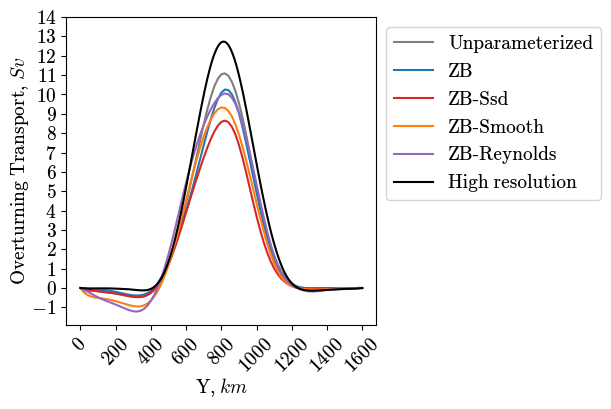

In [34]:
default_rcParams({'axes.formatter.limits': (-5,5)})
for exp, color, label in zip(['bare', 'ZB', 'ZB_ssd', 'ZB_smooth', 'ZB_reynolds', '5km'],
                ['tab:gray', 'tab:blue', 'tab:red', 'tab:orange', 'tab:purple', 'k'],
                ['Unparameterized', 'ZB', 'ZB-Ssd', 'ZB-Smooth', 'ZB-Reynolds', 'High resolution']):
    transport(exp=exp).plot(label=label, color=color)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Overturning Transport, $Sv$')
plt.xlabel('Y, $km$')
plt.yticks(np.arange(-1,15))
plt.xticks(np.arange(0,1800,200), rotation=45)
plt.title('')

# Spectrum

In [63]:
lores = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/bare/output/prog.nc', decode_times=False, chunks={'Time': 1})
hires = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/5km/output/prog.nc', decode_times=False, chunks={'Time': 1})


In [55]:
def logKEz(ds):
    return np.log10(0.5 * (ds.h * (remesh(ds.u**2, ds.e) + remesh(ds.v**2, ds.e))).sum('zl'))

In [66]:
logKEz(lores).hvplot(x='xh', y='yh',cmap='inferno', clim=(-1,3), width=300) + \
logKEz(hires).hvplot(x='xh', y='yh',cmap='inferno', clim=(-1,3), width=300)

:Layout
   .DynamicMap.I  :DynamicMap   [Time]
      :Image   [xh,yh]   (value)
   .DynamicMap.II :DynamicMap   [Time]
      :Image   [xh,yh]   (value)

In [6]:
import xrft
def v_spectrum(ds):
    data = ds.v.sel(yq=800).sel(Time=slice(365*5, None)).isel(zl=0)
    data['xh'] = data['xh'] * 1e+3 # to metres
    sp = xrft.power_spectrum(data, dim='xh').mean('Time')
    sp['freq_xh'] = sp['freq_xh'] * 2 * np.pi
    sp = sp / (2 * np.pi)
    freq = sp.freq_xh
    sp = sp[freq>0]
#     KE_mean = float((0.5 * data**2).mean())
#     KE_sp = float(sp.sum() * (freq[1] - freq[0]))
#     print(KE_mean, KE_sp)
    return sp

In [7]:
def vh_cospectrum(ds):
    v = ds.v.sel(yq=800).sel(Time=slice(365*5, None)).isel(zl=0)
    v['xh'] = v['xh'] * 1e+3 # to metres
    h = remesh(ds.h, ds.v).sel(yq=800).sel(Time=slice(365*5, None)).isel(zl=0)
    h['xh'] = h['xh'] * 1e+3
    
    sp = xrft.cross_spectrum(v, h, dim='xh').mean('Time')
    sp['freq_xh'] = sp['freq_xh'] * 2 * np.pi
    sp = sp / (2 * np.pi)
    freq = sp.freq_xh
    sp = 2 * np.real(sp[freq>0])
    #KE_mean = float((v*h).mean())
    #KE_sp = float(sp.sum() * (freq[1] - freq[0]))
    #print(KE_mean, KE_sp)
    return sp

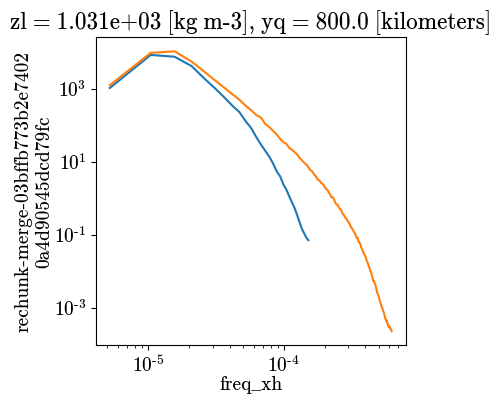

In [199]:
v_spectrum(lores).plot()
v_spectrum(hires).plot()
plt.xscale('log')
plt.yscale('log')

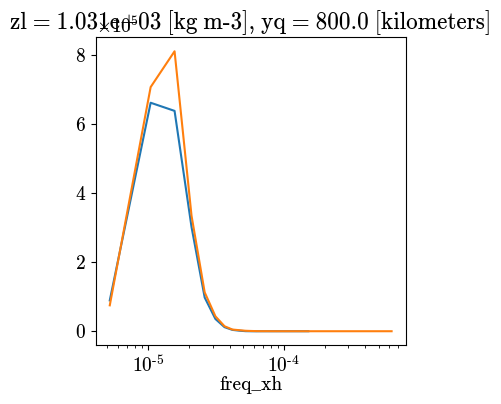

In [196]:
vh_cospectrum(lores).plot()
vh_cospectrum(hires).plot()
plt.xscale('log')

# Final figure

In [45]:
def compute_metrics(folder='bare'):
    trans = transport(folder).compute()
    ds = xr.open_dataset(f'/scratch/pp2681/mom6/Phillips_2layer/simulations/{folder}/output/prog.nc', decode_times=False)
    vsp = v_spectrum(ds).compute()
    cosp = vh_cospectrum(ds).compute()
    return {'trans': trans, 'vsp': vsp, 'cosp': cosp}

In [46]:
d = {}

In [47]:
#for folder in ['bare', 'ZB', 'ZB_ssd', 'ZB_smooth', 'ZB_reynolds', '5km']:
#for folder in ['40km', '40km_ZB', '40km_ZB_ssd', '40km_ZB_smooth', '40km_ZB_reynolds', '5km']:
for folder in ['30km', '30km_ZB', '30km_ZB_ssd', '30km_ZB_smooth', '30km_ZB_reynolds', '5km']:
    d[folder] = compute_metrics(folder)

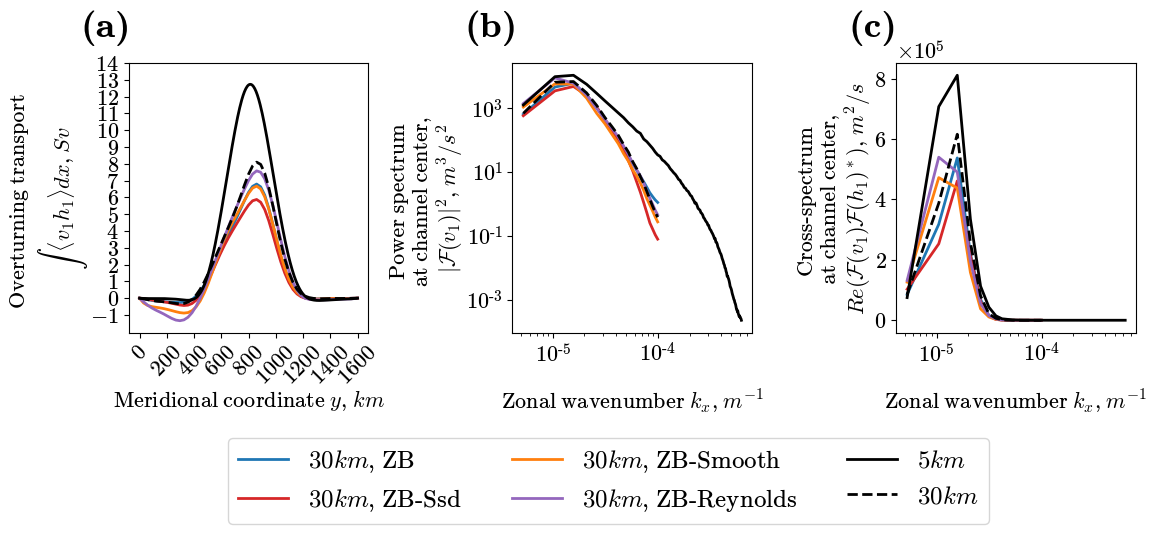

In [48]:
default_rcParams({'axes.formatter.limits': (-5,5), 'figure.subplot.wspace': 0.6, 'font.size': 16, 'lines.linewidth': 2})
plt.figure(figsize=(13,3.5))

#exps = ['ZB', 'ZB_ssd', 'ZB_smooth', 'ZB_reynolds', '5km', 'bare']
#labels = ['$20km$, ZB', '$20km$, ZB-Ssd', '$20km$, ZB-Smooth', '$20km$, ZB-Reynolds', '$5km$', '$20km$']

# exps = ['40km_ZB', '40km_ZB_ssd', '40km_ZB_smooth', '40km_ZB_reynolds', '5km', '40km']
# labels = ['$40km$, ZB', '$40km$, ZB-Ssd', '$40km$, ZB-Smooth', '$40km$, ZB-Reynolds', '$5km$', '$40km$']

exps = ['30km_ZB', '30km_ZB_ssd', '30km_ZB_smooth', '30km_ZB_reynolds', '5km', '30km']
labels = ['$30km$, ZB', '$30km$, ZB-Ssd', '$30km$, ZB-Smooth', '$30km$, ZB-Reynolds', '$5km$', '$30km$']

for exp, color, label, ls in zip(exps,
                ['tab:blue', 'tab:red', 'tab:orange', 'tab:purple', 'k', 'k'],
                labels,
                ['-']*5+['--']):
    plt.subplot(1,3,1)
    d[exp]['trans'].plot(label=label,color=color,ls=ls)
    plt.ylabel('Overturning transport \n$\int ~ \\langle v_1 h_1 \\rangle dx}$, $Sv$')
    plt.xlabel('Meridional coordinate $y$, $km$')
    plt.yticks(np.arange(-1,15))
    plt.xticks(np.arange(0,1800,200), rotation=45)
    plt.title('')
    
    plt.subplot(1,3,2)
    d[exp]['vsp'].plot(label=label,color=color,ls=ls)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Zonal wavenumber $k_x$, $m^{-1}$')
    plt.ylabel('Power spectrum \nat channel center, \n$|\mathcal{F}(v_1)|^2$, $m^3/s^2$')
    plt.title('')
    
    plt.subplot(1,3,3)
    sp = d[exp]['cosp']
    sp.plot(label=label,color=color,ls=ls)
    plt.xscale('log')
    plt.xlabel('Zonal wavenumber $k_x$, $m^{-1}$')
    plt.ylabel('Cross-spectrum \n at channel center, \n$Re(\mathcal{F}(v_1)\mathcal{F}(h_1)^*)$, $m^2/s$')
    plt.title('')
set_letters(fontsize=25, y=1.1)
plt.legend(ncol=3, loc='center', bbox_to_anchor=(-1.2,-0.55), fontsize=18)
plt.gcf().align_labels()
plt.savefig('Phillips_30km.pdf')

# Movie

In [49]:
def logKEz(ds):
    return np.log10(0.5 * (ds.h * (remesh(ds.u**2, ds.e) + remesh(ds.v**2, ds.e))).sum('zl'))

In [147]:
lores = xr.open_dataset('/scratch/pp2681/mom6/Phillips_2layer/simulations/bare/output/prog.nc', decode_times=False)

In [148]:
d = {}
#for exp in ['30km', '5km', '30km_ZB', '30km_ZB_ssd', '30km_ZB_smooth', '30km_ZB_reynolds']:
#for exp in ['40km', '5km', '40km_ZB', '40km_ZB_ssd', '40km_ZB_smooth', '40km_ZB_reynolds']:
for exp in ['bare', '5km', 'ZB', 'ZB_ssd', 'ZB_smooth', 'ZB_reynolds']:
    ds = xr.open_dataset(f'/scratch/pp2681/mom6/Phillips_2layer/simulations/{exp}/output/prog.nc', decode_times=False)
    d[exp] = logKEz(ds).compute()
    if exp=='5km':
        dss = xr.Dataset()
        for key in ['u', 'v', 'h', 'e']:
            dss[key] = remesh(ds[key], lores[key]).compute()
        d['5km_coarse'] = logKEz(dss).compute()
    print(exp)

bare
5km
ZB
ZB_ssd
ZB_smooth
ZB_reynolds


In [150]:
default_rcParams({ 'axes.formatter.limits': (-5,5)})
def plot(idx=-1):
    plt.figure(figsize=(9,6))
#     labels = ['$30km$', '$30km$, ZB', '$30km$, ZB-Ssd', '$5km$ coarsened', '$30km$, ZB-Smooth', '$30km$, ZB-Reynolds']
#     labels = ['$40km$', '$40km$, ZB', '$40km$, ZB-Ssd', '$5km$ coarsened', '$40km$, ZB-Smooth', '$40km$, ZB-Reynolds']
    labels = ['$20km$', '$20km$, ZB', '$20km$, ZB-Ssd', '$5km$ coarsened', '$20km$, ZB-Smooth', '$20km$, ZB-Reynolds']
#     for col, exp in enumerate(['30km', '30km_ZB', '30km_ZB_ssd', '5km_coarse', '30km_ZB_smooth', '30km_ZB_reynolds']):
#     for col, exp in enumerate(['40km', '40km_ZB', '40km_ZB_ssd', '5km_coarse', '40km_ZB_smooth', '40km_ZB_reynolds']):
    for col, exp in enumerate(['bare', 'ZB', 'ZB_ssd', '5km_coarse', 'ZB_smooth', 'ZB_reynolds']):
        plt.subplot(2,3,col+1)
        im = d[exp].isel(Time=idx).plot(vmin=-1, vmax=3, cmap='inferno', add_colorbar=False)
        plt.xlabel('')
        plt.ylabel('')
        plt.title(labels[col])
        plt.axis('off')
    Time = lores.Time
    plt.suptitle(f'{int(Time.isel(Time=idx))} day')
        
    plt.colorbar(im, ax=plt.gcf().axes, label='$\log_{10}(\int ~~ \\frac{1}{2} |\mathbf{u}|^2 dz)$')

In [152]:
create_animation(plot, range(730), 'Phillips-20km.gif', deezering=False, dpi=100, FPS=15)

Animation at FPS=15 will last for 48.666666666666664 seconds


In [6]:
ds = xr.open_dataset('/scratch/db194/mom6/Phillips_2layer/ocean.stats.nc', decode_times=False)